# Predicción de sueldo

El objetivo de este proyecto es poder estimar el sueldo de una persona basandonos en las respuestas obtenidas por las encuestas de sysarmy.

El texto apunta a que cualquier persona, sin necesariamente tenre conocimento técnico de programación o estadística, pueda leerlo.

## Las encuestas

Sysarmy efectúa dos veces por año desde hace varios semestres unas encuestas de sueldo con muchas respuestas en Argentina. Armaremos modelos de Machine Learning que puedan usar esa información para poder predecir sueldos de otra persona, una herramienta muy útil para la gente que busca trabajo.

Tengamos en cuenta que los datos de estas encuestas no son completamente confiables por varios motivos. Por un lado, la gente que responde está autoseleccionada, es decir que no necesariamente se una muestra representativa de la población. Sólo gente que se enteró de la encuesta y tuvo la suficiente voluntad de completarla lo hizo. Esto puede hacer que personas que tengan más conexiones se hayan enterado y gente que no es tan activa en la comunidad no, por ejemplo, y las primeras quizás tienen más oportunidades laborales.

Otro posible problema es que no hay validación alguna sobre los datos o la gente que responde. Podrían haber usuarios maliciosos completando información incorrecta adrede, por ejemplo empresas que quieren bajar las expectativas salariales del mercado. También hay gente que responde incorrectamente por no haber leído bien la consigna.

Un último inconveniente a señalar es lo dispar que pueden ser las formas de comprender una pregunta. Por ejemplo al ingresar el salario uno elige si es neto o bruto, pero algunos rubros pueden tener subsidios o ingresos no remunerativos que generan confusión al momento de responder.

Sin embargo, la encuesta tiene una cantidad de respuestas significativa y no hay motivos para creer que haya distorciones intencionales, por lo que los datos son interesantes de analizar aunque debemos tener cierta cautela al momento de tomar conclusiones.

## Sobre mí

Trabajo como programador desde 2006 pero estoy incursionado en el campo de Machine Learning desde hace poco, por lo que no me considero un experto en el tema.

## Librerías

Usaré pandas, matplotlib y scikitlearn. No voy a entrar en detalles de cómo funciona cada una porque sería demasiado largo y tedioso.

In [1]:
%matplotlib inline 
import pandas as pd

df = pd.read_csv('Encuesta de remuneración salarial de sysarmy - 2018.1 - Argentina.csv', skiprows=3)

Ahora cargamos el csv de resultados en un DataFrame (el equivalente a una matriz). Para generar un modelo de Machine Learning vamos a necesitar transformarlo en una matriz que sólo tenga valores numéricos. Empezamos graficando los datos que tenemos, esto nos va a dar una idea de los datos que existen.

In [2]:
print('\n'.join(df.columns.tolist()))

Me identifico
Tengo
Argentina
Años de experiencia
Años en el puesto actual
¿Gente a cargo?
¿Cuánta?
Nivel de estudios alcanzado
Estado
Carrera
Realizaste cursos de especialización
Trabajo de
Tecnologías que utilizás
Tecnologías que utilizás.1
Tecnologías que utilizás.2
Automation o funcional?
Tecnologías que utilizás.3
Tecnologías que utilizás.4
¿Tenés guardias?
Cuánto cobrás por guardia (en tu moneda local)
¿Porcentaje, bruto o neto?
Tipo de contrato
Salario mensual (en tu moneda local)
¿Bruto o neto?
¿Qué tan conforme estás con tu sueldo?
Cómo creés que está tu sueldo con respecto a julio 2017
Recibís algún tipo de bono
A qué está atado el bono
¿Tuviste ajustes por inflación en 2017?
¿De qué % fue el ajuste?
Cantidad de empleados
¿Cambiaste de empresa en los últimos 6 meses?
¿Cuál fue el principal motivo de cambio?
Beneficios extra


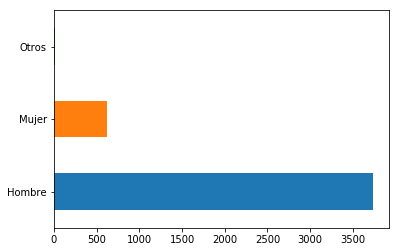

In [3]:
df['Me identifico'].value_counts().plot.barh()

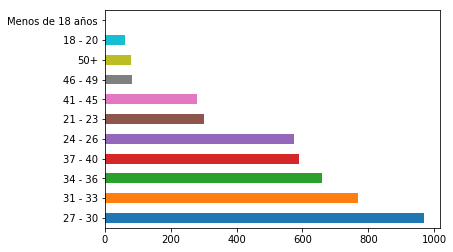

In [4]:
df['Tengo'].value_counts().plot.barh()

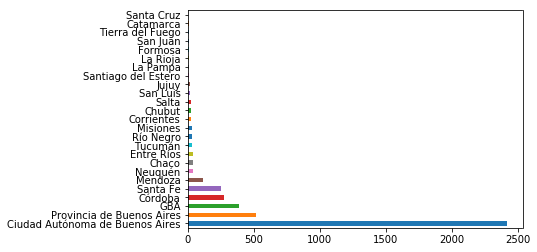

In [5]:
df['Argentina'].value_counts().plot.barh()

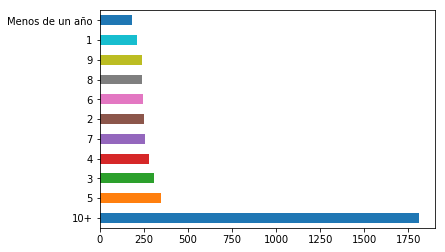

In [6]:
df['Años de experiencia'].value_counts().plot.barh()

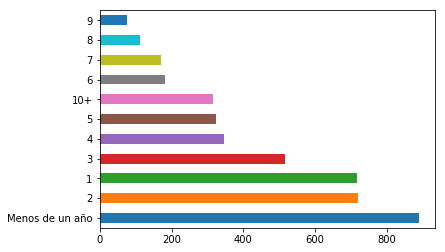

In [7]:
df['Años en el puesto actual'].value_counts().plot.barh()

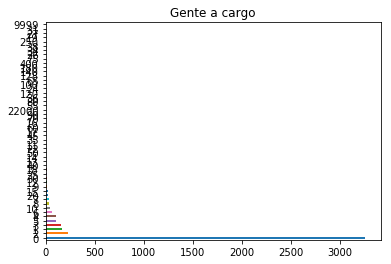

In [8]:
df['¿Cuánta?'].value_counts().plot.barh(title='Gente a cargo')

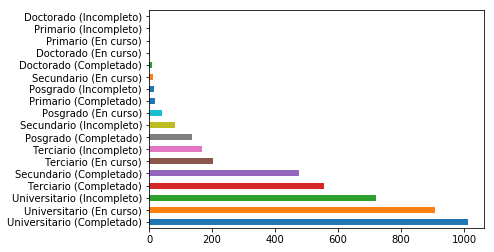

In [9]:
df.apply(lambda x: '{} ({})'.format(x['Nivel de estudios alcanzado'], x['Estado']), axis=1).value_counts().plot.barh()

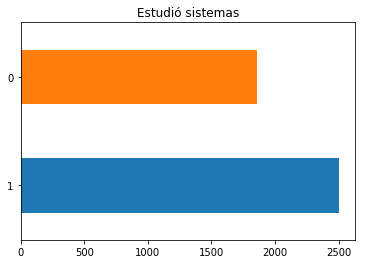

In [10]:
def is_desistemas(x):
    x = str(x).lower()
    return int('sistemas' in x or 'informática' in x or 'informatica' in x or 'computación' in x or 'computacion' in x or 'programador' in x or 'programación' in x)
df['Carrera'].map(is_desistemas).value_counts().plot.barh(title='Estudió sistemas')

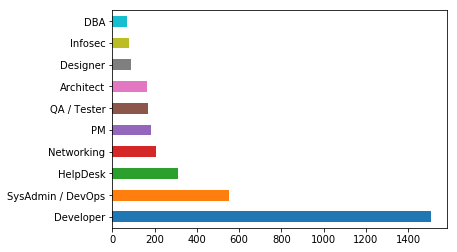

In [11]:
df['Trabajo de'].value_counts().head(10).plot.barh()

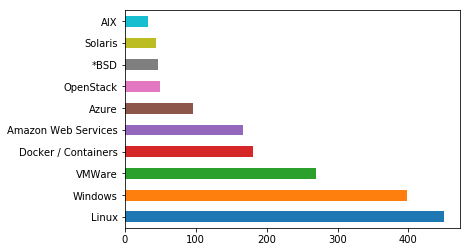

In [12]:
tech_count = {}
for x in df['Tecnologías que utilizás'].dropna():
    for key in x.split(','):
        key = key.strip()
        tech_count[key] = tech_count.get(key, 0) + 1
pd.Series(tech_count).sort_values(ascending=False).head(10).plot.barh()

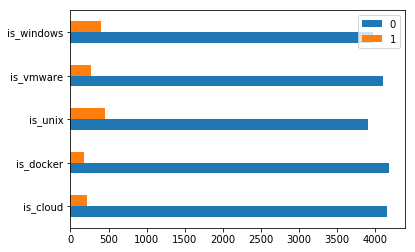

In [13]:
d = {}
for key, tech in {
        'unix': ('Linux', '*BSD', 'AIX', 'OpenStack', 'Solaris', 'HP-UX'),
        'windows': ('Windows',),
        'vmware': ('VMWare',),
        'docker': ('Docker / Containers',),
        'cloud': ('Azure', 'Amazon Web Services'),
    }.items():
    d['is_{}'.format(key)] = df['Tecnologías que utilizás'].apply(lambda x: int(any(map(lambda t: t in str(x), tech))))
pd.DataFrame({x: v.value_counts() for x, v in d.items()}).T.plot.barh()


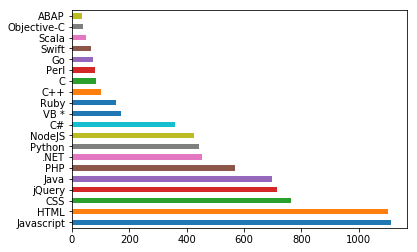

In [14]:
tech_count = {}
for x in pd.concat((df['Tecnologías que utilizás.1'], df['Tecnologías que utilizás.2'])).dropna():
    for key in x.split(','):
        key = key.strip()
        tech_count[key] = tech_count.get(key, 0) + 1
pd.Series(tech_count).sort_values(ascending=False).head(20).plot.barh()

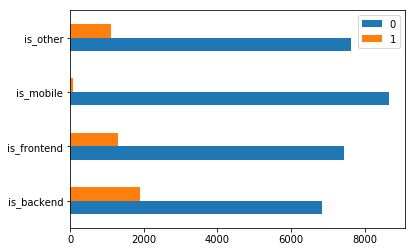

In [15]:
d = {}
for key, tech in {
        'frontend': ('Javascript', 'HTML', 'CSS', 'jQuery'),
        'backend': ('Java', 'PHP', 'Python', '.NET', 'NodeJS', 'C#', 'Ruby', 'Perl', 'Go', 'Scala'),
        'other': ('VB*', 'C++', 'C', 'ABAP'),
        'mobile': ('Swift', 'Objective-C')
    }.items():
    d['is_{}'.format(key)] = pd.concat((df['Tecnologías que utilizás.1'], df['Tecnologías que utilizás.2'])).apply(lambda x: int(any(map(lambda t: t in str(x), tech))))
pd.DataFrame({x: v.value_counts() for x, v in d.items()}).T.plot.barh()


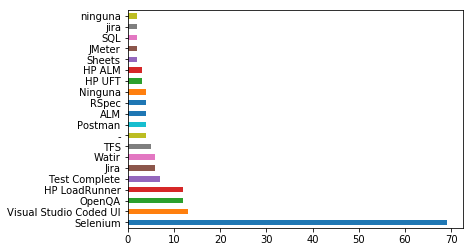

In [16]:
tech_count = {}
for x in df['Tecnologías que utilizás.3'].dropna():
    for key in x.split(','):
        key = key.strip()
        tech_count[key] = tech_count.get(key, 0) + 1
pd.Series(tech_count).sort_values(ascending=False).head(20).plot.barh()

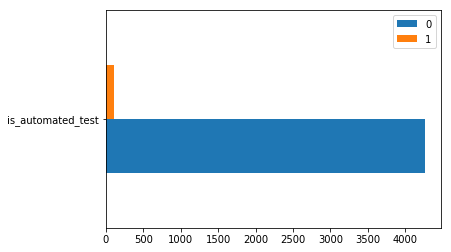

In [17]:
d = {}
for key, tech in {
        'automated_test': ('Selenium', 'Visual Studio Coded UI', 'OpenQA', 'HP LoadRunner', 'Test Complete', 'Watir', 'Postman', 'RSpec', 'JMeter'),
    }.items():
    d['is_{}'.format(key)] = df['Tecnologías que utilizás.3'].apply(lambda x: int(any(map(lambda t: t in str(x), tech))))
pd.DataFrame({x: v.value_counts() for x, v in d.items()}).T.plot.barh()
